In [1]:
import os
import torch
import random
import numpy as np
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torchvision import transforms
from torch.nn import TripletMarginLoss
from torch.utils.data import Dataset, DataLoader
from concurrent.futures import ThreadPoolExecutor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader, random_split

# **Checking GPU**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 2060


# **Histogram Image Size**

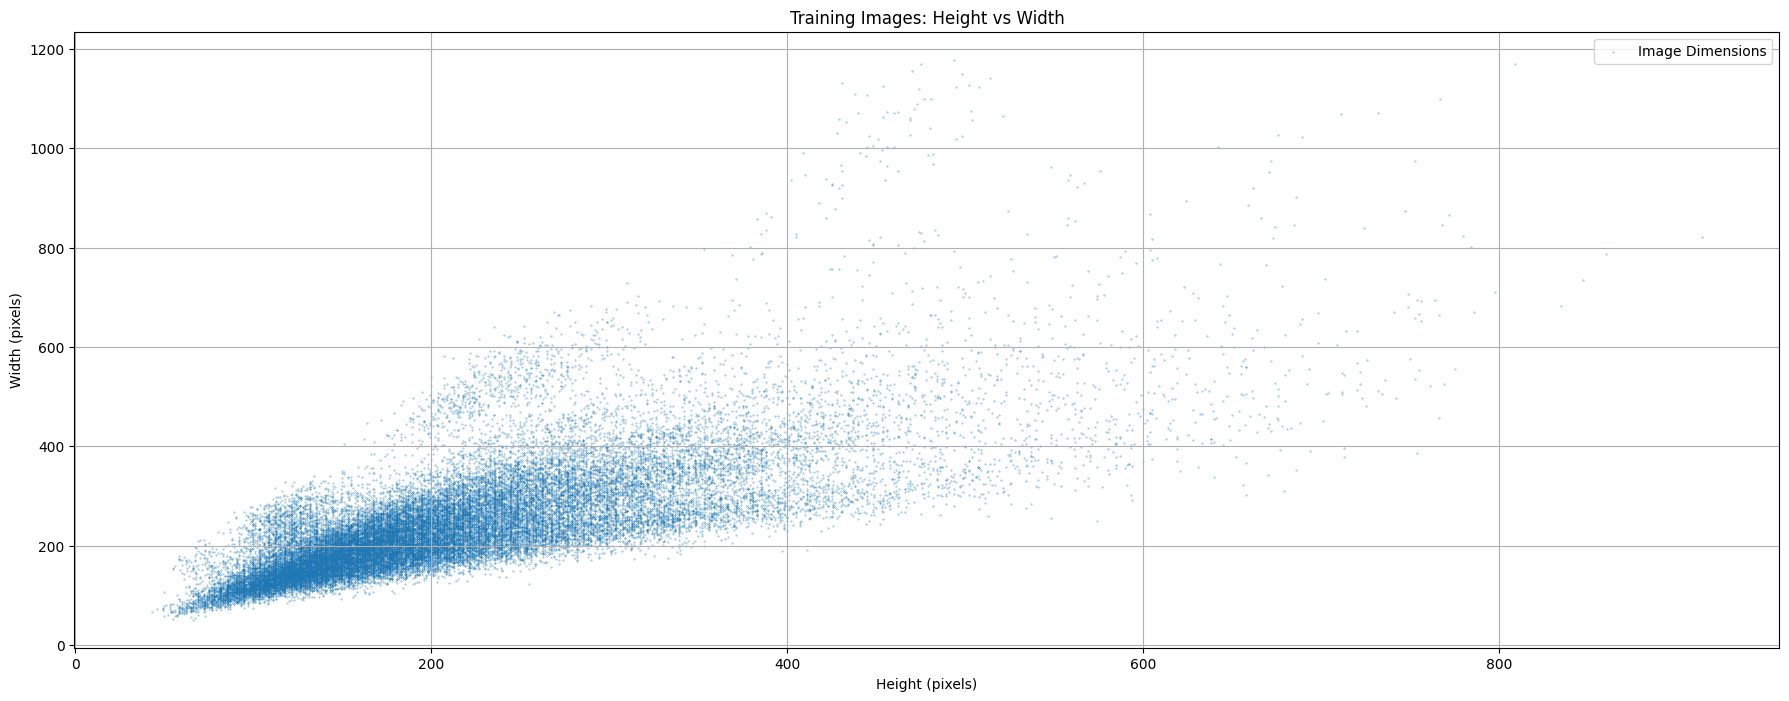

In [3]:
def process_image(file_path):
    try:
        with Image.open(file_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def collect_dimensions(image_dir):
    dimensions = []

    with ThreadPoolExecutor() as executor:
        futures = []
        for file_name in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file_name)
            if os.path.isfile(file_path) and file_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                futures.append(executor.submit(process_image, file_path))

        for future in futures:
            result = future.result()
            if result:
                dimensions.append(result)

    return dimensions

def plot_histogram(dimensions, title):
    heights = [dim[1] for dim in dimensions]
    widths = [dim[0] for dim in dimensions]

    plt.figure(figsize=(22, 8))
    plt.scatter(heights, widths, alpha=0.7, s=0.10, label="Image Dimensions")
    plt.title(title)
    plt.xlabel("Height (pixels)")
    plt.ylabel("Width (pixels)")
    plt.grid(True)
    plt.legend()
    plt.show()

train_dir = "D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train"

train_dimensions = collect_dimensions(train_dir)

if train_dimensions:
    plot_histogram(train_dimensions, "Training Images: Height vs Width")
else:
    print("No dimensions collected for training images.")

# **Dataset Loading & Triplet Generator**

In [4]:
class VERIDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for img_name in os.listdir(data_dir):
            if img_name.endswith('.jpg'):
                self.image_paths.append(img_name)
                car_id = int(img_name.split('_')[0])
                self.labels.append(car_id)

        # Create a mapping for car IDs to indices
        self.id_to_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in self.id_to_indices:
                self.id_to_indices[label] = []
            self.id_to_indices[label].append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = os.path.join(self.data_dir, self.image_paths[index])
        label = self.labels[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label

    def get_triplet(self):
        # Randomly pick a car class (anchor class)
        anchor_class = random.choice(list(self.id_to_indices.keys()))

        # Get the positive and negative samples
        anchor_idx = random.choice(self.id_to_indices[anchor_class])
        positive_idx = random.choice(self.id_to_indices[anchor_class])

        # Ensure the positive sample is different from the anchor
        while positive_idx == anchor_idx:
            positive_idx = random.choice(self.id_to_indices[anchor_class])

        # Pick a negative class (different from anchor class)
        negative_class = random.choice([cls for cls in self.id_to_indices.keys() if cls != anchor_class])
        negative_idx = random.choice(self.id_to_indices[negative_class])

        return anchor_idx, positive_idx, negative_idx

# **Loaded Data**

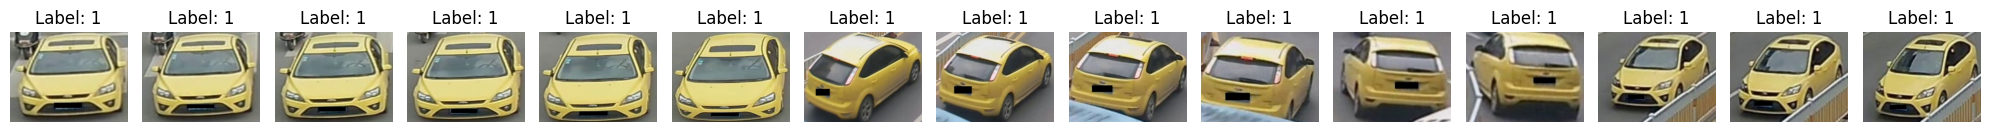

In [5]:
data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train'
transform = transforms.Compose([transforms.Resize((196, 256)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
dataset = VERIDataset(data_dir, transform=transform)

num_samples = 15
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    img, label = dataset[i]
    img_np = img.permute(1, 2, 0).numpy() 
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = (img_np * 255).astype('uint8')

    axes[i].imshow(img_np)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [6]:
class TripletDataset(Dataset):
    def __init__(self, veri_dataset, indices=None):
        self.veri_dataset = veri_dataset
        self.indices = indices if indices else list(range(len(veri_dataset)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        # Fetch the triplet using the get_triplet method of VERIDataset
        dataset_idx = self.indices[index]
        anchor_idx, positive_idx, negative_idx = self.veri_dataset.get_triplet()
        anchor, _ = self.veri_dataset[anchor_idx]
        positive, _ = self.veri_dataset[positive_idx]
        negative, _ = self.veri_dataset[negative_idx]
        return anchor, positive, negative

# **Checking Generated Triplets**

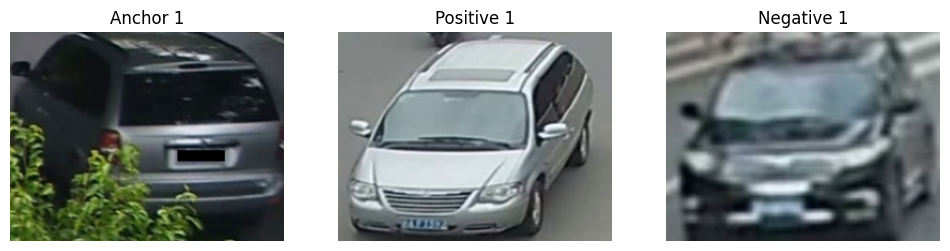

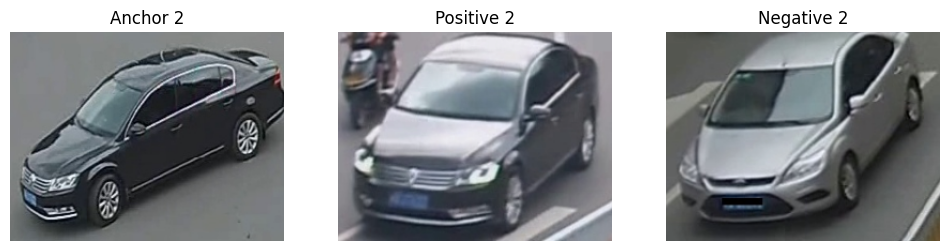

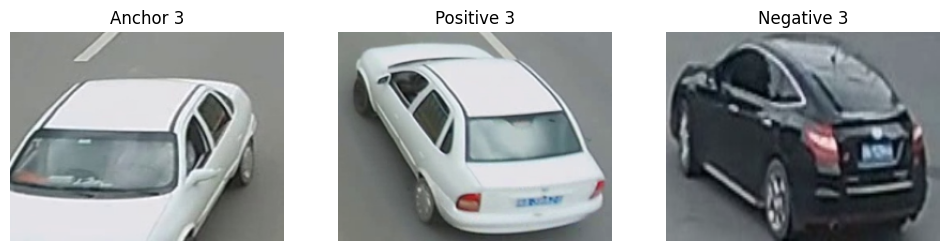

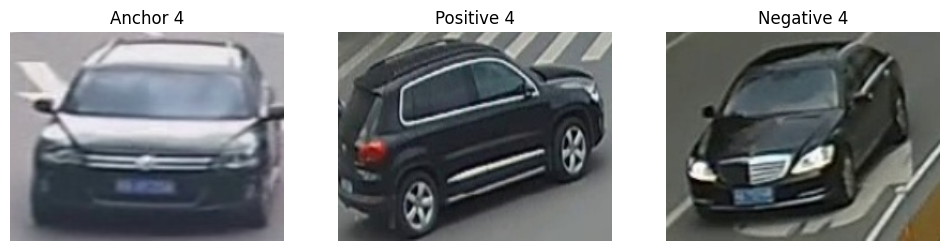

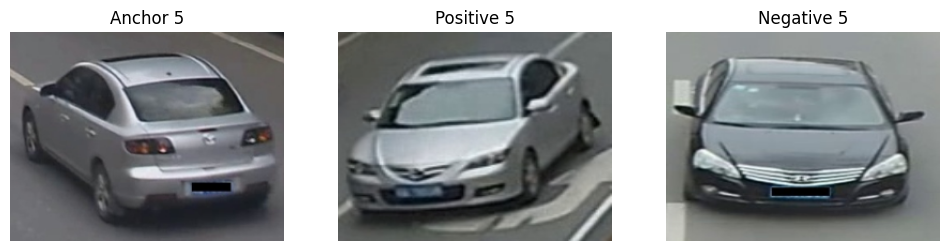

In [7]:
def to_numpy(tensor_img):
    img_np = tensor_img.permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
    img_np = (img_np * 255).astype('uint8')  # Convert to 0-255 range
    return img_np

# Visualization function for triplet samples
def show_triplet_samples(dataset, num_samples=5):
    for i in range(num_samples):
        # Get a triplet (anchor, positive, negative)
        anchor_idx, positive_idx, negative_idx = dataset.get_triplet()

        # Retrieve the images for the triplet
        anchor, _ = dataset[anchor_idx]
        positive, _ = dataset[positive_idx]
        negative, _ = dataset[negative_idx]

        # Plot the triplet images sequentially
        fig = plt.figure(figsize=(12, 4))

        # Plot anchor image
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.imshow(to_numpy(anchor))
        ax1.set_title(f"Anchor {i + 1}")
        ax1.axis("off")

        # Plot positive image
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(to_numpy(positive))
        ax2.set_title(f"Positive {i + 1}")
        ax2.axis("off")

        # Plot negative image
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.imshow(to_numpy(negative))
        ax3.set_title(f"Negative {i + 1}")
        ax3.axis("off")

        # Display the images sequentially
        plt.show()

# Example usage
data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train' 
transform = transforms.Compose([transforms.Resize((196, 256)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
veri_dataset = VERIDataset(data_dir, transform=transform)

# Show triplet samples
show_triplet_samples(veri_dataset, num_samples=5)

In [8]:
def print_sorted_triplet_labels(dataset, num_samples=5):
    """
    Collect triplets, sort them by the anchor label, and print the labels of anchor, positive, and negative.
    """
    triplets = []

    # Collect triplets
    for i in range(num_samples):
        anchor_idx, positive_idx, negative_idx = dataset.get_triplet()
        _, anchor_label = dataset[anchor_idx]
        _, positive_label = dataset[positive_idx]
        _, negative_label = dataset[negative_idx]

        triplets.append((anchor_label, positive_label, negative_label))

    # Sort triplets by anchor label
    triplets.sort(key=lambda triplet: triplet[0])

    # Print sorted triplets
    for i, (anchor_label, positive_label, negative_label) in enumerate(triplets):
        print(f"Triplet {i + 1}:")
        print(f"  Anchor ID: {anchor_label}")
        print(f"  Positive ID: {positive_label}")
        print(f"  Negative ID: {negative_label}")
        print("-" * 50)

# Example usage
data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train' 
transform = transforms.Compose([
    transforms.Resize((196, 196)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

veri_dataset = VERIDataset(data_dir, transform=transform)

# Print the sorted triplet labels
print_sorted_triplet_labels(veri_dataset, num_samples=15)


Triplet 1:
  Anchor ID: 32
  Positive ID: 32
  Negative ID: 112
--------------------------------------------------
Triplet 2:
  Anchor ID: 124
  Positive ID: 124
  Negative ID: 509
--------------------------------------------------
Triplet 3:
  Anchor ID: 131
  Positive ID: 131
  Negative ID: 175
--------------------------------------------------
Triplet 4:
  Anchor ID: 152
  Positive ID: 152
  Negative ID: 534
--------------------------------------------------
Triplet 5:
  Anchor ID: 169
  Positive ID: 169
  Negative ID: 277
--------------------------------------------------
Triplet 6:
  Anchor ID: 222
  Positive ID: 222
  Negative ID: 539
--------------------------------------------------
Triplet 7:
  Anchor ID: 351
  Positive ID: 351
  Negative ID: 302
--------------------------------------------------
Triplet 8:
  Anchor ID: 377
  Positive ID: 377
  Negative ID: 526
--------------------------------------------------
Triplet 9:
  Anchor ID: 429
  Positive ID: 429
  Negative ID: 502


# **REID CNN**

In [13]:
# class TripletCNN(nn.Module):
#     def __init__(self):
#         super(TripletCNN, self).__init__()

#         # First convolution layer: 7x7 kernel, stride 5, padding 3, 12 channels
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=5, padding=3)
#         self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)  # No downsampling here

#         # Second convolution layer: 3x3 kernel, stride 1, padding 1, 24 channels
#         self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

#         # Third convolution layer: 3x3 kernel, stride 1, padding 1, 32 channels (no downsampling)
#         self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces to 32x32

#         # Fourth convolution layer: 3x3 kernel, stride 1, padding 1, 64 channels (no downsampling)
#         self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

#         # Adaptive pooling to prevent size issues
#         self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Flatten()

#     def forward(self, x):
#         x1 = F.relu(self.conv1(x))
#         x2 = self.pool1(x1)

#         x3 = F.relu(self.conv2(x2))
#         x4 = F.relu(self.conv3(x3))
#         x5 = self.pool2(x4)

#         x6 = F.relu(self.conv4(x5))
#         x7 = self.global_pool(x6)
#         x8 = self.fc(x7)

#         return x8

class TripletCNN(nn.Module):
    def __init__(self):
        super(TripletCNN, self).__init__()

        # First convolution layer: 7x7 kernel, stride 5, padding 3, 12 channels
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=7, stride=5, padding=3)
        self.bn1 = nn.BatchNorm2d(12)  # Batch normalization for conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)  # No downsampling here

        # Second convolution layer: 3x3 kernel, stride 1, padding 1, 24 channels
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(24)  # Batch normalization for conv2

        # Third convolution layer: 3x3 kernel, stride 1, padding 1, 32 channels (no downsampling)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)  # Batch normalization for conv3
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size (downsampling)

        # Fourth convolution layer: 3x3 kernel, stride 1, padding 1, 64 channels (no downsampling)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)  # Batch normalization for conv4

        # Adaptive pooling to ensure the feature map is 32x32 before flattening
        self.adaptive_pool = nn.AdaptiveAvgPool2d((32, 32))  # Forces 32x32 dimensions
        self.fc = nn.Flatten()

    def forward(self, x):
        # First convolution layer
        x1 = F.leaky_relu(self.bn1(self.conv1(x)))
        x2 = self.pool1(x1)

        # Second convolution layer
        x3 = F.leaky_relu(self.bn2(self.conv2(x2)))

        # Third convolution layer
        x4 = F.leaky_relu(self.bn3(self.conv3(x3)))
        x5 = self.pool2(x4)

        # Fourth convolution layer
        x6 = F.leaky_relu(self.bn4(self.conv4(x5)))

        # Adaptive pooling to ensure 32x32 feature map
        x7 = self.adaptive_pool(x6)

        # Flatten the output
        x8 = self.fc(x7)

        return x8


# **Training**

In [9]:
def calculate_accuracy(anchor_out, positive_out, negative_out):
    pos_dist = torch.nn.functional.pairwise_distance(anchor_out, positive_out,p=2)
    neg_dist = torch.nn.functional.pairwise_distance(anchor_out, negative_out,p=2)
    correct = (pos_dist < neg_dist).sum().item()
    accuracy = correct / anchor_out.size(0)
    return accuracy

In [10]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0

        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()

            # Forward pass
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            # Calculate loss
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            accuracy = calculate_accuracy(anchor_out, positive_out, negative_out)

            train_loss += loss.item()
            train_accuracy += accuracy

        # Calculate average loss and accuracy for training
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0

        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                # Forward pass
                anchor_out = model(anchor)
                positive_out = model(positive)
                negative_out = model(negative)

                # Calculate loss
                loss = criterion(anchor_out, positive_out, negative_out)

                # Calculate accuracy
                accuracy = calculate_accuracy(anchor_out, positive_out, negative_out)

                val_loss += loss.item()
                val_accuracy += accuracy

        # Calculate average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

# **Accuracy and Loss Curves**

In [11]:
def plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# **Main Function**

In [25]:
# data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train'
# transform = transforms.Compose([transforms.Resize((196, 256)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# full_dataset = VERIDataset(data_dir, transform)
# train_size = int(0.7 * len(full_dataset))
# val_size = len(full_dataset) - train_size
# train_indices, val_indices = random_split(list(range(len(full_dataset))), [train_size, val_size])

# train_triplet_dataset = TripletDataset(full_dataset, indices=train_indices)
# val_triplet_dataset = TripletDataset(full_dataset, indices=val_indices)

# train_loader = DataLoader(train_triplet_dataset, batch_size=256, shuffle=True)
# val_loader = DataLoader(val_triplet_dataset, batch_size=256, shuffle=False)

# model = TripletCNN()
# optimizer = optim.AdamW(model.parameters(), lr=0.00001)
# criterion = TripletMarginLoss(margin=3.0, p=2)

# train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=80)
# plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)
# torch.save(model.state_dict(), 'triplet_cnn.pth')

from torchvision import models
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.nn import TripletMarginLoss
from torchvision import transforms

# Data Directory and Transform
data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_train'
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 to avoid small input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset and Data Loaders
full_dataset = VERIDataset(data_dir, transform)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(list(range(len(full_dataset))), [train_size, val_size])

train_triplet_dataset = TripletDataset(full_dataset, indices=train_indices)
val_triplet_dataset = TripletDataset(full_dataset, indices=val_indices)

train_loader = DataLoader(train_triplet_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=16, shuffle=False)

# Define MobileNetV2 Model for Triplet Loss
class MobileNetV2Triplet(torch.nn.Module):
    def __init__(self, embedding_size=128):
        super(MobileNetV2Triplet, self).__init__()
        # Load the pretrained MobileNetV2 model
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        # Modify the classifier to output the desired embedding size
        self.mobilenet.classifier[1] = torch.nn.Linear(self.mobilenet.classifier[1].in_features, embedding_size)

    def forward(self, x):
        return self.mobilenet(x)

# Initialize Model
model = MobileNetV2Triplet(embedding_size=128)

# Training Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.00001)
criterion = TripletMarginLoss(margin=3.0, p=2)

# Train the Model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, criterion, device, epochs=10
)

# Plot Learning Curves
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Save the Model
torch.save(model.state_dict(), 'mobilenetv2_triplet.pth')

Epoch 1/10 - Train Loss: 0.9885, Train Accuracy: 0.8851 - Val Loss: 0.5300, Val Accuracy: 0.9277


KeyboardInterrupt: 

# **Test on Data**

In [24]:
model_path = 'triplet_cnn.pth'
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Function to preprocess images
def preprocess_image(image_path, transform):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension (1, C, H, W)
    return img

def compute_distance(model, image1_path, image2_path, transform, margin=3.0, device='cuda'):
    image1 = preprocess_image(image1_path, transform).to(device)
    image2 = preprocess_image(image2_path, transform).to(device)
    
    with torch.no_grad():
        feature1 = model(image1)
        feature2 = model(image2)
    
    distance = F.pairwise_distance(feature1, feature2,p=2).item()
    similarity = distance < margin
    
    if similarity:
        print(f"Images are similar (distance: {distance:.4f})")
    else:
        print(f"Images are different (distance: {distance:.4f})")
    
    return distance, similarity

def main():

    image1_path = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest\anchor.jpg'  
    image2_path = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest\0 (1).jpg'
    
    transform = transforms.Compose([transforms.Resize((196, 256)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    model = TripletCNN().to(device)
    model = load_model(model, model_path)
    
    distance, similarity = compute_distance(model, image1_path, image2_path, transform, margin=3.0, device=device)

if __name__ == "__main__":
    main()

Images are different (distance: 118.5349)


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14824\3004099191.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=to

In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np

model_path = 'triplet_cnn.pth'

def preprocess_image(image_path, transform):
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img.unsqueeze(0)
    return img

def compute_distance(model, image1_path, image2_path, transform, margin=3.0, device='cuda'):
    image1 = preprocess_image(image1_path, transform).to(device)
    image2 = preprocess_image(image2_path, transform).to(device)
    
    with torch.no_grad():
        feature1 = model(image1)
        feature2 = model(image2)
    
    distance = F.pairwise_distance(feature1, feature2, p=2).item()
    similarity = distance < margin
    
    return distance, similarity

def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
    model.eval()
    return model


dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\mytest'
anchor_path = os.path.join(dir, 'anchor.jpg')

transform = transforms.Compose([transforms.Resize((196, 256)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

model = TripletCNN().to('cuda')
model = load_model(model, model_path)

y_true = []
y_pred = []

for filename in os.listdir(dir):
    if filename == 'anchor.jpg':
        continue
    image_path = os.path.join(dir, filename)
    label = int(filename.split(' ')[0]) 
    _, similarity = compute_distance(model, anchor_path, image_path, transform, margin=3.0, device='cuda')
    
    y_true.append(label)
    y_pred.append(1 if similarity else 0)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10  0]
 [10  0]]


C:\Users\ahmad\AppData\Local\Temp\ipykernel_14824\1859293045.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=t

# **DataSet Visualization**

d:\Computer Vision\FYP\TASK 1\env\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\ahmad\AppData\Local\Temp\ipykernel_17080\1064996841.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


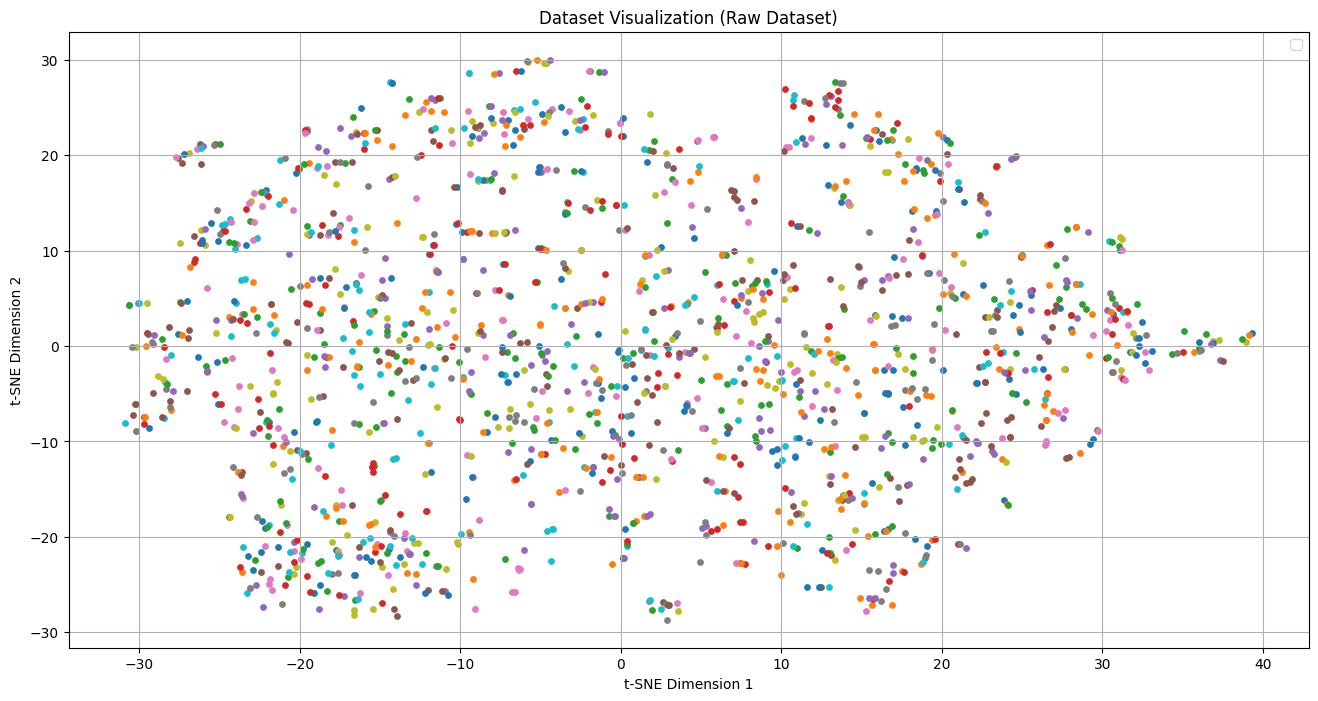

In [18]:
def plot_dataset_embeddings(dataset, device, title_suffix="", max_samples=None):
    sampled_indices = torch.randperm(len(dataset))[:max_samples].tolist()

    embeddings = []
    labels = []

    for idx in sampled_indices:
        img, label = dataset[idx]
        # Resize the image to a smaller size to reduce dimensionality
        img = resize(img, (32, 32)).numpy().flatten()  # Flatten the resized image
        embeddings.append(img)
        labels.append(label)  # Append scalar label

    # Convert embeddings and labels to NumPy arrays
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Use t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(16, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        # plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1],label=f"Class {label}", s=15)
        plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1], s=15)

    plt.title(f"Dataset Visualization {title_suffix}")
    plt.legend()
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = r'D:\Computer Vision\FYP\TASK 1\env\TrackNet-X\DataSet\VeRi\image_query'
transform = transforms.Compose([transforms.Resize((220, 220)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
full_dataset = VERIDataset(data_dir, transform)
plot_dataset_embeddings(dataset=full_dataset,device=device, title_suffix="(Raw Dataset)", max_samples=3500)

# **Model Visualization**

C:\Users\ahmad\AppData\Local\Temp\ipykernel_14824\269377981.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('triplet_cnn.pth', map_loca

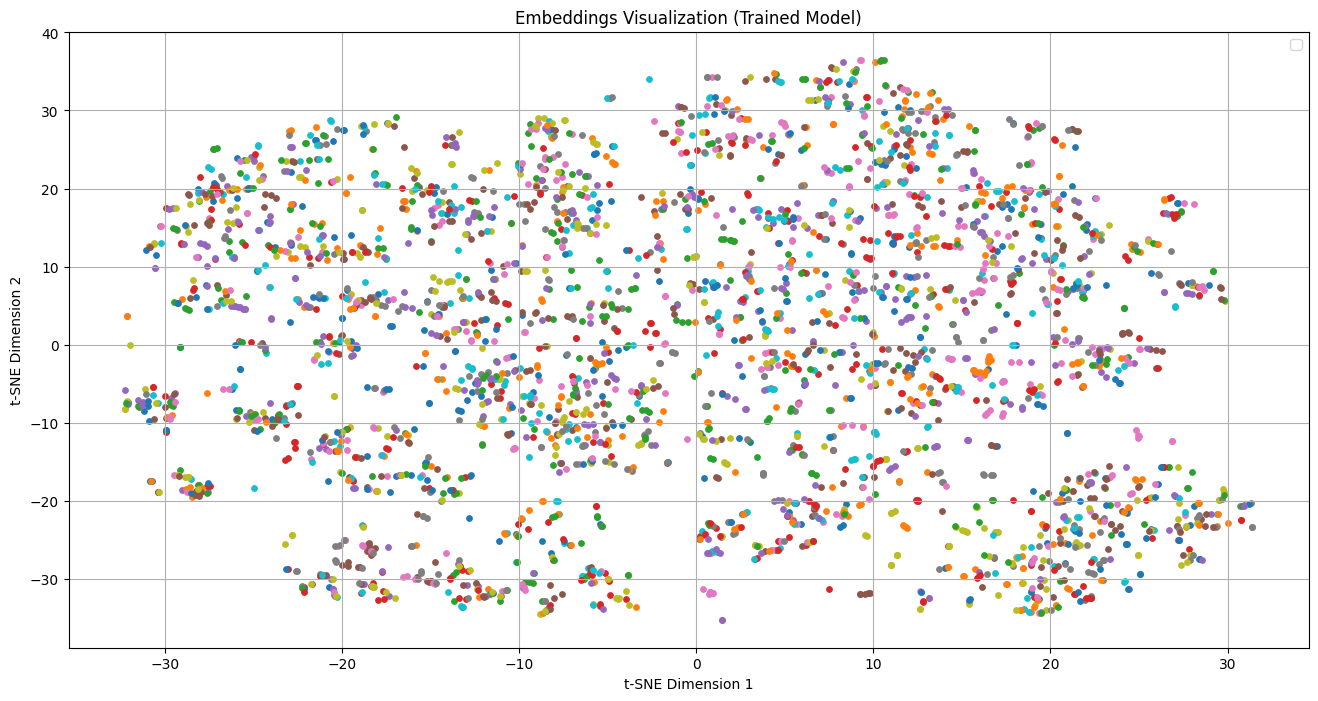

In [26]:
def plot_triplet_embeddings(model, dataset, device, title_suffix="", max_samples=None):
    model.to(device)
    model.eval()

    embeddings = []
    labels = []

    # Randomly sample max_samples items from the dataset
    sampled_indices = torch.randperm(len(dataset))[:max_samples].tolist()

    with torch.no_grad():
        for idx in sampled_indices:
            img, label = dataset[idx]
            img = img.unsqueeze(0).to(device)
            embedding = model(img).cpu().numpy()
            embeddings.append(embedding)
            labels.append(label)

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)  # Convert labels to a NumPy array

    # Use t-SNE for dimensionality reduction to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(16, 8))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = np.where(labels == label)
        # plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1],label=f"Class {label}", s=15)
        plt.scatter(reduced_embeddings[indices, 0],reduced_embeddings[indices, 1], s=15)


    plt.title(f"Embeddings Visualization {title_suffix}")
    plt.legend()
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()

model = TripletCNN().to(device)
model.load_state_dict(torch.load('triplet_cnn.pth', map_location=device))
plot_triplet_embeddings(model=model, dataset=full_dataset,  device=device, title_suffix="(Trained Model)", max_samples=3500)